# Table of Contents
- [Imports](#imp)
- [cleaning](#clean)
- [visualization](#vis)
    - [mapping](#map)
        - [animation trail](#anim)
    - [time series](#time)
        - [time series](#1)
        - [winter t-max change](#2)
        - [winter t-min change](#3)
- [conclusion](#conc)

<a id='imp'></a>
## Imports

In [1]:
from mpl_toolkits.basemap import Basemap
import  netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib
import numpy  as np
import pandas as pd
import warnings
import time
from scipy import stats
from datetime import datetime
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

In [2]:
path_tmax= "Central_North_Egypt_(CNE_V1.0)_Tmax_1981-2017.nc"
path_tmin= "Central_North_Egypt_(CNE_V1.0)_Tmin_1981-2017.nc"
data = nc.Dataset(path_tmax);   data_tmin = nc.Dataset(path_tmin); 

In [3]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Central North Region of Egypt Maximum Temperature Dataset
    short title: CNE Tmax
    Version: CNE_01
    Time Span: 1/1/1981 - 31/12/2017
    DOI: 10.6084/m9.figshare.7504232
    references: NA
    history: M.S. Nashwan On Sun Dec 23 17:18:07 2018
    institution: Construction and Building Engineering, College of Engineering and Technology, Arab Academy for Science, Technology and Maritime Transport (AASTMT), Cairo, 2033 - Elhorria, Egypt
    Title: Central North Region of Egypt Maximum Temperature Dataset
    Short title: CNE Tmax
    References: Nashwan, M. S., Shahid, S., & Chung, E.-S. (2019). Development of high-resolution daily gridded temperature datasets for the central north region of Egypt. Scientific Data, 6(1), 138. doi:10.1038/s41597-019-0144-0
    History: M.S. Nashwan On Wed Aug 07 21:51:01 2019
    Institute: Construction and Building Engineering, College of En

In [4]:
data['temperature']

<class 'netCDF4._netCDF4.Variable'>
float32 temperature(Day, lat, lon)
    units: celsius
unlimited dimensions: 
current shape = (13514, 42, 71)
filling on, default _FillValue of 9.969209968386869e+36 used

In [5]:
data['temperature'][:][9000:9002,0,0]

masked_array(data=[35.86, 36.6 ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [6]:
data.variables['lon'][0:10]

masked_array(data=[29.5 , 29.55, 29.6 , 29.65, 29.7 , 29.75, 29.8 , 29.85,
                   29.9 , 29.95],
             mask=False,
       fill_value=1e+20)

In [7]:
data['Day'].shape

(13514,)

In [8]:
lats = data['lat'][:]
lons = data['lon'][:]
times = data['Day'][:]
tempreture_data = data['temperature'][:][:,:,:]

In [9]:
lats_ = data_tmin['lat'][:]
lons_ = data_tmin['lon'][:]
times_ = data_tmin['Day'][:]
tempreture_data_ = data_tmin['temperature'][:][:,:,:]

<a id='clean'></a>
## ***cleaning***

In [10]:
tempreture_data[0,:,:].data

array([[18.31, 18.31, 18.21, ..., 18.07, 17.98, 17.38],
       [18.31, 18.32, 18.05, ..., 17.77, 17.57, 17.28],
       [18.23, 18.25, 18.06, ..., 17.97, 17.58, 17.08],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]], dtype=float32)

In [11]:
np.isnan(tempreture_data[-5,:,:]).sum()

394

In [12]:
tempreture_data[0,:,:][~np.isnan(tempreture_data[0,:,:])].mean()

18.38968

In [13]:
nulls = np.isnan(tempreture_data).sum() # 5 millions
print(nulls)

5324516


In [14]:
np.isnan(data_tmin.variables['temperature']).sum()

5324516

In [15]:
int(tempreture_data[:,:,:].flatten().shape - nulls) # 35 mil is not nul

34974232

In [16]:
# wrong it gets diffrent shape cannot reshape it to the original
cleaned_temp = tempreture_data.copy()
cl = cleaned_temp[:,:,:][~np.isnan(cleaned_temp[:,:,:])]
cl.shape

(34974232,)

In [17]:
cleaned_temp = tempreture_data.copy()
cleaned_temp_min = tempreture_data_.copy()

for i in range(len(times)):
    # the diffrence in shapes will generate error
    #cleaned_temp[i,:,:]= cleaned_temp[i,:,:][~np.isnan(cleaned_temp[i,:,:])]

    cleaned_temp[i,:,:][np.isnan(cleaned_temp[i,:,:])]= np.nanmean(cleaned_temp[i,:,:])
    cleaned_temp_min[i,:,:][np.isnan(cleaned_temp_min[i,:,:])]= np.nanmean(cleaned_temp_min[i,:,:])

In [18]:
tempreture_data[:,:,:].shape,type(tempreture_data),cleaned_temp[:,:,:].shape,type(cleaned_temp)

((13514, 42, 71),
 numpy.ma.core.MaskedArray,
 (13514, 42, 71),
 numpy.ma.core.MaskedArray)

**we filled the nans on every day data with mean temp on that day** 

<a id='vis'></a>
## ****Visualization****

<a id='map'></a>
### ***map***

In [19]:
# to ignore annoying python warnings
warnings.filterwarnings('ignore')

In [20]:
lats.shape, lons.shape, tempreture_data.shape

((42,), (71,), (13514, 42, 71))

In [21]:
max(lats),min(lats)

(31.55, 29.5)

In [22]:
def map_temperature(df,ax,ind:int=0,day:str='1981-01-01',show_text=True) -> "plt.plot()":    
    # 1. Draw the map background
    #fig = plt.figure();
    #fig.set_facecolor('white');
    
    m = Basemap(projection='lcc', resolution='l',
        lat_0=30.5, lon_0=30.5,
        width=.7E6, height=.4E6);

    m.shadedrelief();
    m.drawcoastlines(color='gray');

    # Make the plot continuous
    temp_cyclic, lons_cyclic = addcyclic(df[ind, :, :], lons);

    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats);
    # Transforms lat/lon into plotting coordinates for projection
    x, y = m(lon2d, lat2d);
    # Plot temperature
    cs = m.contourf(x, y, temp_cyclic, 35, cmap=plt.cm.Spectral_r);
    if show_text:
        ## colorbar and lables
        #cbar = plt.colorbar(cs, ticks=[-1, 0, 1], orientation='horizontal', shrink=0.7);
        cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.7);
        """o=int(np.max(df[ind, :, :]))
        m=int(np.mean(df[ind, :, :]))
        l=int(np.min(df[ind, :, :]))
        cbar.ax.set_xticklabels([o,m , l])"""
        cbar.set_label('Tmax ⁰c',color='black',);
        plt.title('T-max in central egypt at {}'.format(str(day)),color='black');
    ax=cs
    return ax

In [23]:
times[500]

19820516.0

without nans


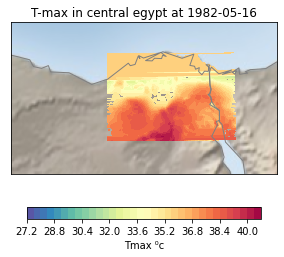

In [24]:
#the nans in data were for water covered areas
fig, ax = plt.subplots()
print("without nans")
#map_temperature(cleaned_temp,fig,0,'1981-01-01')  
map_temperature(cleaned_temp,fig,500,'1982-05-16')  
plt.show()

with nans


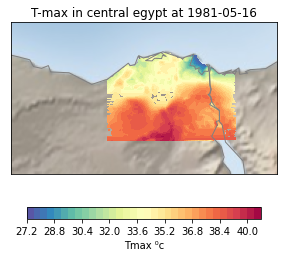

In [25]:
print("with nans")
map_temperature(tempreture_data,fig,500,'1981-05-16')
plt.show()

**can't make separete plots they always overlap :-D**

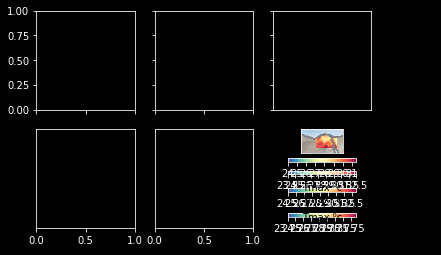

In [26]:
" 6 days"
with plt.style.context('dark_background'):
   fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
   for i in range(2):
      for j in range(2):
         day = '1990-01-0' +str(i*2+j+1)
         ax[i, j] = map_temperature(tempreture_data,fig,1000+i*2+j,day)

**can't make overlapping plots they're always seperate 😂**

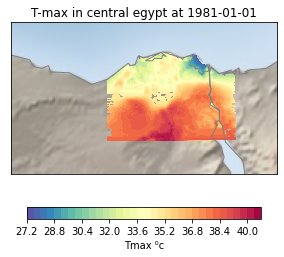

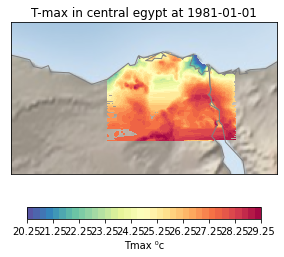

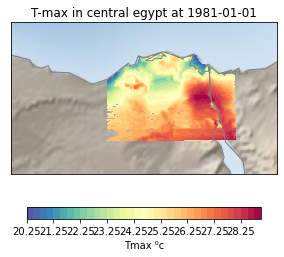

In [27]:
fig =plt.figure();
grid = plt.GridSpec(1, 1)

# assign
first= fig.add_subplot(grid[0, 0]) 
#fisrt_right= fig.add_subplot(grid[0, 1])
#second= fig.add_subplot(grid[1, 0]) 
#second_right= fig.add_subplot(grid[1, 1])

# plot
for i in range(3):
    plt.cla()
    plt.clf()
    map_temperature(tempreture_data,first,i*2+500,'1981-01-01')
    plt.pause(.5)
#map_temperature(tempreture_data,fisrt_right,365,'1982-01-01',False)
#second  = map_temperature(tempreture_data,365*2,'1983-01-01',False)
#second_right  = map_temperature(tempreture_data,365*3,'1984-01-01',False)

1981-01-01


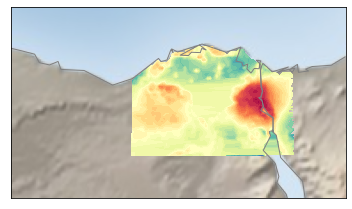

1982-01-01


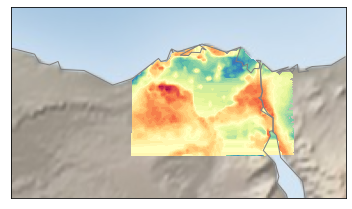

In [28]:
#fg =plt.Figure()

fig, ax = plt.subplots()
for year in range(0,2):
    day = str(1981+year) + '-01-01' 
    
    plt.cla()
    plt.clf()
    map_temperature(tempreture_data, ax, year*365, day, False)
    print(day)
    
    plt.pause(.4)
    
    """#plt.show()
    if year == 0 :
        #ax.show()
        plt.show()
    #plt.clf()
    #fig.show()
    
    #plt.close(fig)
    #fig.clear()
    plt.show()
    time.sleep(0.3)
    #ax.clear()
    #plt.close(fig)
    fig.clear()"""

<a id='anim'></a>
#### **animation trial**

tried to make animation to overwrite the map with the new one but didn't workout

In [29]:
import matplotlib.animation as animation

0 0
The animation function must return a sequence of Artist objects.


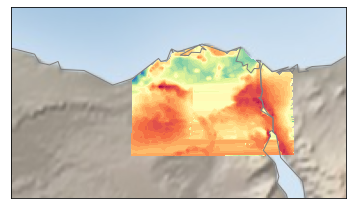

In [30]:
try:
    def initial():
        #cs.set_data([], [],[],35,cmap=plt.cm.Spectral_r)
        cs = map_.contourf(x, y, temp_cyclic, 35, cmap=plt.cm.Spectral_r);
        print("hi")
        
        return map_.plot([],[])

    map_ = Basemap(projection='lcc', resolution='l',
        lat_0=30.5, lon_0=30.5,
        width=.7E6, height=.4E6);

    map_.shadedrelief();
    map_.drawcoastlines(color='gray');

    temp_cyclic, lons_cyclic = addcyclic(tempreture_data[0, :, :], lons);

    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats);
    # Transforms lat/lon into plotting coordinates for projection
    x, y = map_(lon2d, lat2d);
    #x,y = map_(0,0)

    i=0
    cs = map_.contourf(x, y, temp_cyclic, 35, cmap=plt.cm.Spectral_r);
    ind=0
    def anim(i):
        global ind 
        print(i,ind)
        
        temp_cyclic, lons_cyclic = addcyclic(tempreture_data[50, :, :], lons);
        ind+=1
        i+=1

        # Create 2D lat/lon arrays for Basemap
        lon2d, lat2d = np.meshgrid(lons_cyclic, lats);
        # Transforms lat/lon into plotting coordinates for projection
        x, y = map_(lon2d, lat2d); 
        cs = map_.contourf(x, y, temp_cyclic, 35, cmap=plt.cm.Spectral_r);
        return cs

    anim = animation.FuncAnimation(plt.gcf(), anim, 
                                frames=20, interval=500, blit=True)
    anim.save('mapp.gif')
except Exception as err:
    print(err)

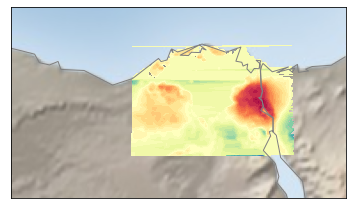

In [31]:
a=0
map_temperature(cleaned_temp,a,0,'1981-01-01',False);

<a id='time'></a>
### ***time series***

<a id='1'></a>
#### **temp change daily over the years**

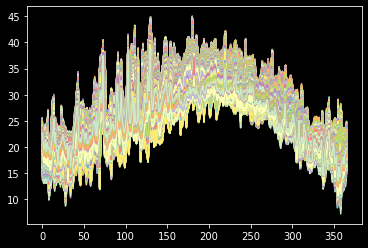

In [32]:
try:
    with plt.style.context('dark_background'):
        for i in  [0,20,36]:
            a= [tempreture_data[i*366+(366-j):i*366+366-j +1,:,:].flatten() for j in reversed(range(366))]
            plt.plot(np.arange(366),a)
except:
    pass

**it's a mess we should smooth the data to get an clear result**

In [33]:
avg_temp_day_over_years =[[((cleaned_temp[j*365+ i,:,:] + cleaned_temp_min[j*365+ i,:,:])/2.0).flatten().mean()
 for i in range(365)
 ]
 for j in range(2017-1981+1)
 ]

In [34]:
df_avg= pd.DataFrame(avg_temp_day_over_years)
df_avg.head(2)

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,13.130529,13.480419,13.874324,13.914237,12.263430,12.723754,13.435273,12.939741,12.742347,9.939656,...,16.557119,16.639899,16.763365,15.811392,16.840340,17.693121,14.124353,14.122714,15.148372,15.611945
1,14.499460,14.703599,13.938771,13.281879,11.659132,13.117598,13.029386,13.633466,13.684152,12.363978,...,12.872550,13.119509,13.249104,13.906401,15.562455,16.133072,12.183122,13.013993,12.014766,12.456019


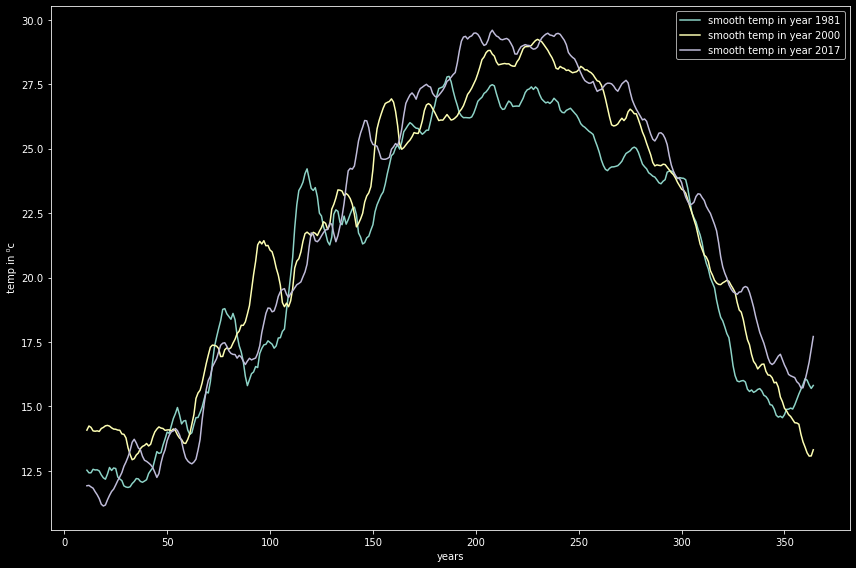

In [35]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(12,8))
    plt.plot(np.arange(365),pd.DataFrame(np.array(avg_temp_day_over_years)[0,:]).rolling(window=12).mean());
    plt.plot(np.arange(365),pd.DataFrame(np.array(avg_temp_day_over_years)[20,:]).rolling(window=12).mean());
    plt.plot(np.arange(365),pd.DataFrame(np.array(avg_temp_day_over_years)[-1,:]).rolling(window=12).mean());
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.legend(['smooth temp in year 1981','smooth temp in year 2000','smooth temp in year 2017'])
    plt.tight_layout()

* **We could see that in year 2017 it had the lowest overall temp in the first 60 days of the year (Jan , Feb)**
* **And highest overall temp peak from day 150 (May, in spring) to the end of the year**


<a id='2'></a>
### **mean t-max change in 11,12,01,02 months of the year (represents the winter in egypt)**

In [36]:
times[30+30+29], times[273+151],    2017-1981+1

(19810331.0, 19820301.0, 37)

In [37]:
mean_t_max_over_years = dict()
temps=[]
for i in range(2017-1981+1):
    temps.append(np.mean(cleaned_temp[ i*365+273 : i*365 +273+151  ,:,:]))

mean_t_max_over_years['temp'] = temps

In [38]:
mean_df = pd.DataFrame(mean_t_max_over_years)
mean_df.head(3)

,temp
0,22.375765
1,21.198111
2,22.430492


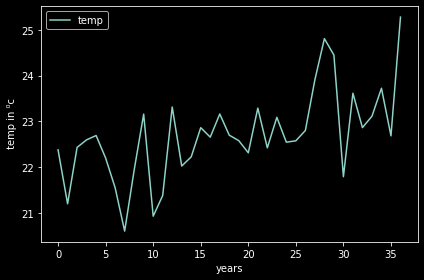

In [39]:
with plt.style.context('dark_background'):
    mean_df.plot()
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

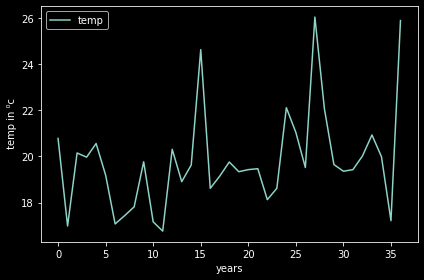

In [40]:
"what people really experince in everyday life "
mode_t_max_over_years = dict()
temps=[]
for i in range(2017-1981+1):
    temps.append(stats.mode(tempreture_data[ i*365+273 : i*365 +273+151  ,:,:].flatten())[0][0])
mode_t_max_over_years['temp'] = temps

mode_df = pd.DataFrame(mode_t_max_over_years)
with plt.style.context('dark_background'):
    mode_df.plot();
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

<a id='3'></a>
### **mean t-min change in 11,12,01,02 months of the year (represents the winter in egypt)**

In [41]:
mean_t_min_over_years = dict()
temps=[]
for i in range(2017-1981+1):
    temps.append(np.mean(cleaned_temp_min[ i*365+273 : i*365 +273+151  ,:,:]))

mean_t_min_over_years['temp'] = temps

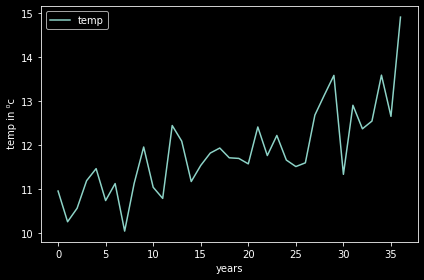

In [42]:
mean_df_ = pd.DataFrame(mean_t_min_over_years)
with plt.style.context('dark_background'):
    mean_df_.plot(); 
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

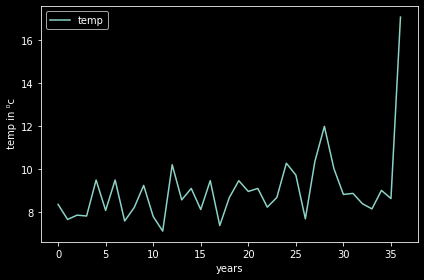

In [43]:
mode_t_min_over_years = dict()
temps=[]
for i in range(2017-1981+1):    
    temps.append(stats.mode(tempreture_data_[ i*365+273 : i*365 +273+151  ,:,:].flatten())[0][0])

mode_t_min_over_years['temp'] = temps
mode_df_ = pd.DataFrame(mode_t_min_over_years)
with plt.style.context('dark_background'):
    mode_df_.plot(); 
    plt.xlabel("years")
    plt.ylabel(" temp in ⁰c")
    plt.tight_layout()

<a id='conc'></a>
## ***Conclusion***
* We could see that how climate change in central egypt over the years
* In winter the climate becomes colder than before
* And summer gets hotter every year